In [ ]:
import torch


In [1]:
import torch
import torch.nn as nn
import math
from collections import defaultdict
from transformers import PreTrainedModel

class PositionalEncoding(nn.Module):
    """
    正弦位置编码，每一层一个独立向量，形状为 [1, num_layers, dim]。
    """
    def __init__(self, num_layers, d_model):
        super().__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.register_buffer("pe", self._build_encoding())

    def _build_encoding(self):
        position = torch.arange(self.num_layers).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * -(math.log(10000.0) / self.d_model))
        pe = torch.zeros(self.num_layers, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # [1, num_layers, d_model]

    def forward(self, device):
        return self.pe.to(device)  # [1, num_layers, d_model]

class TransformerProjector(nn.Module):
    """
    使用 Transformer 架构对所有层的 LoRA 参数生成进行建模。
    每一层作为一个 token，输入为文档嵌入加 token embedding 加位置编码。
    """
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim, num_heads=4):
        super().__init__()
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.token_embeddings = nn.Parameter(torch.randn(num_layers, input_dim))  # 可学习 token 表示
        self.pos_encoding = PositionalEncoding(num_layers, input_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, doc_embed):
        # doc_embed: [1, input_dim]
        batch_size = doc_embed.size(0)

        tokens = self.token_embeddings.unsqueeze(0).expand(batch_size, -1, -1)  # [B, L, D]
        doc_expand = doc_embed.unsqueeze(1).expand(-1, self.num_layers, -1)     # [B, L, D]
        pos_embed = self.pos_encoding(doc_embed.device).expand(batch_size, -1, -1)  # [B, L, D]

        x = tokens + doc_expand + pos_embed  # [B, L, D]
        out = self.transformer(x.transpose(0, 1)).transpose(0, 1)  # [B, L, D]
        return self.output_layer(out)  # [B, L, output_dim]

class ParameterTranslator(nn.Module):
    """
    参数生成模块：输入文档 → 动态生成各层 MLP 模块的 LoRA 参数（使用 Transformer）
    支持位置编码按位加法，模型初始化自动读取维度参数。
    """
    def __init__(self, embedding_model: PreTrainedModel, llm_model: PreTrainedModel, 
                 lora_rank=2, projector_hidden_dim=512):
        super().__init__()

        self.input_dim = embedding_model.config.hidden_size if hasattr(embedding_model.config, 'hidden_size') else embedding_model.config.d_model
        self.num_layers = llm_model.config.num_hidden_layers
        self.ff_hidden_dim = llm_model.config.intermediate_size
        self.lora_rank = lora_rank

        self.module_names = ["down_proj", "up_proj", "gate_proj"]

        self.projectors = nn.ModuleList([
            TransformerProjector(
                num_layers=self.num_layers,
                input_dim=self.input_dim,
                hidden_dim=projector_hidden_dim,
                output_dim=self._get_lora_dim(m),
                num_heads=4
            )
            for m in self.module_names
        ])

    def _get_lora_dim(self, module_name):
        return self.lora_rank * (self.input_dim + self.ff_hidden_dim)

    @property
    def device(self):
        return next(self.parameters()).device


    def forward(self, doc_embed):
        """
        输入：doc_embed [1, input_dim]
        输出：字典形式 LoRA 参数（每层 × 每模块）
        """
        outputs = defaultdict(list)
        device = doc_embed.device

        for i, module_name in enumerate(self.module_names):
            lora_matrix = self.projectors[i](doc_embed)  # [1, num_layers, output_dim]
            lora_matrix = lora_matrix.squeeze(0)  # [num_layers, output_dim]

            for layer_idx in range(self.num_layers):
                lora_out = lora_matrix[layer_idx]  # [output_dim]

                if module_name == "down_proj":
                    A = lora_out[:self.lora_rank * self.ff_hidden_dim].view(self.lora_rank, self.ff_hidden_dim)
                    B = lora_out[self.lora_rank * self.ff_hidden_dim:].view(self.input_dim, self.lora_rank)
                else:
                    A = lora_out[:self.lora_rank * self.input_dim].view(self.lora_rank, self.input_dim)
                    B = lora_out[self.lora_rank * self.input_dim:].view(self.ff_hidden_dim, self.lora_rank)

                key_A = f"base_model.model.model.layers.{layer_idx}.mlp.{module_name}.lora_A.weight"
                key_B = f"base_model.model.model.layers.{layer_idx}.mlp.{module_name}.lora_B.weight"

                outputs[key_A] = A
                outputs[key_B] = B

        return outputs

In [4]:
from transformers import T5EncoderModel, AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model
import torch
# Initialize models
embedding_model = T5EncoderModel.from_pretrained("./models/t5-base",device_map="cpu")
embedding_tokenizer = AutoTokenizer.from_pretrained("./models/t5-base")
llm_model = AutoModelForCausalLM.from_pretrained("./models/Llama-3.2-1B-Instruct",device_map="cpu",torch_dtype=torch.bfloat16)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=2,
    lora_alpha=32,
    lora_dropout=0.0,
    target_modules=["down_proj", "up_proj", "gate_proj"],  # 指定 LoRA 注入的模块
)
print(llm_model)
llm_model = get_peft_model(llm_model, peft_config)
# embedding_model.eval()
# llm_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [ ]:
from train_my_dyprag import *

# Initialize translator
translator = ParameterTranslator(
    embedding_model=embedding_model,
    llm_model=llm_model,
    lora_rank=2,
    projector_hidden_dim=1024,
)#66193921
translator=translator.to("cpu").to(torch.bfloat16)
print(translator)
total_params = sum(p.numel() for p in translator.parameters())
print(f"Total parameters: {total_params}")
# translator.train()
# # Generate dummy input
# doc_embed = torch.randn(1, translator.input_dim).to(translator.device).to(torch.bfloat16)  # [1, input_dim]

# # Forward pass
# output = translator(doc_embed)

# # Show sample output
# sample_keys = list(output.keys())[:6]
# summary = {
#     "input_dim": translator.input_dim,
#     "num_layers": translator.num_layers,
#     "ff_hidden_dim": translator.ff_hidden_dim,
#     "total_predicted_keys": len(output),
#     "sample_keys": sample_keys,
#     "sample_shapes": {k: output[k].shape for k in sample_keys}
# }
# summary


/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ParameterTranslator(
  (doc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (projectors): ModuleList(
    (0-2): 3 x TransformerProjector(
      (pos_encoding): PositionalEncoding()
      (transformer): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=False)
            )
            (linear1): Linear(in_features=768, out_features=512, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
            (linear2): Linear(in_features=512, out_features=768, bias=False)
            (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.0, inplace=False)
            (dropout2): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (output_layer): Seque

In [ ]:
from train_my_dyprag import *

# Initialize translator
# translator = CrossAttentionParameterTranslator(
#     embedding_model=embedding_model,
#     llm_model=llm_model,
#     lora_rank=2,
#     projector_hidden_dim=1024,
#     attn_heads=8,
#     attn_ff_dim=1024,
#     cross_layers=3,
#     encoder_layers=3,
# )#122157313
translator = CrossAttentionParameterTranslator(
    embedding_model=embedding_model,
    llm_model=llm_model,
    lora_rank=2,
    projector_hidden_dim=2560,
    attn_heads=8,
    attn_ff_dim=1024,
    cross_layers=4,
    encoder_layers=4,
)#238975489
translator=translator.to("cpu").to(torch.bfloat16)
print(translator)
total_params = sum(p.numel() for p in translator.parameters())
print(f"Total parameters: {total_params}")



CrossAttentionParameterTranslator(
  (doc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (projectors): ModuleList(
    (0-2): 3 x CrossAttentionProjector(
      (cross_attns): ModuleList(
        (0-3): 4 x MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (linear1): Linear(in_features=768, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1024, out_features=768, bias=True)
            (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      

In [8]:
from torchinfo import summary
print(translator.input_dim)
summary(translator, input_size=(1, translator.input_dim))

768


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [PositionalEncoding: 3]

In [ ]:
import os
# print(os.getcwd())
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from utils import delta_inject, delta_remove
import time

class PassageDataset(Dataset):
    def __init__(self, passages):
        self.passages = passages

    def __len__(self):
        return len(self.passages)

    def __getitem__(self, idx):
        return self.passages[idx]

# 示例：自定义 collate_fn 处理 passage 文本为字典结构
def custom_collate_fn(batch):
    return batch  # 如果 batch 是文本列表，在主循环中做进一步处理即可

class DyPRAGTrainer:
    def __init__(self, 
                 translator,            # ParameterTranslator
                 embedding_model,       # HuggingFace encoder (e.g., T5, BERT)
                 llm_model,             # HuggingFace CausalLM + PEFT
                 llm_tokenizer,             # Tokenizer for LLM input
                 embedding_tokenizer,    # Tokenizer for embedding model input
                 lr=1e-5,
                 scheduler_type="cosine",     # lr_scheduler type
                 log_tool=None,         # None or 'wandb'
                 devices=None,
                #  {              # 控制每个模型的设备
                #      'translator': 'cuda:0',
                #      'embedding_model': 'cuda:0',
                #      'llm_model': 'cuda:0'
                #  },
                 log_steps=10,          # 每多少步打印一次 loss
                 saving_steps=100,      # 每多少步保存一次翻译器参数
                 save_path="./models/model_a"  # 保存路径
                 ):
        if devices is not None:
            self.translator = translator.to(devices['translator'])
            self.embedding_model = embedding_model.to(devices['embedding_model'])
            self.llm_model = llm_model.to(devices['llm_model'])
            self.devices = devices
        else:
            self.translator = translator
            self.embedding_model = embedding_model
            self.llm_model = llm_model
            self.devices = {"translator": translator.device,
                            "embedding_model": embedding_model.device,
                            "llm_model": llm_model.device}

        self.embedding_tokenizer = embedding_tokenizer
        self.llm_tokenizer = llm_tokenizer
        self.optimizer = optim.AdamW(self.translator.parameters(), lr=lr)
        if scheduler_type == "cosine":
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.log_tool = log_tool
        self.log_steps = log_steps
        self.saving_steps = saving_steps
        self.save_path = save_path
        self.global_step = 0

        if self.log_tool == "wandb":
            import wandb
            name=time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            wandb.init(project="DyPRAG-Pretrain",name=name)

    def _get_doc_embed(self, passage):
        with torch.no_grad():
            # print(passage)
            inputs = self.embedding_tokenizer(passage, return_tensors="pt", padding=True, truncation=True).to(self.devices['embedding_model']).to(torch.bfloat16)
            print(inputs.device)
            print(self.embedding_model.device)
            output = self.embedding_model.encode(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], return_dict=True)
            pooled = output.last_hidden_state  # [B, L, D]
            pooled_sentence = torch.mean(pooled, dim=1)  # [B, D]
            return pooled_sentence.to(self.devices['translator'])

    def _construct_lm_input(self, passage):
        input_text = passage.strip()
        inputs = self.llm_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
        labels = inputs.input_ids.clone()
        labels[labels == self.llm_tokenizer.pad_token_id] = -100
        return {
            "input_ids": inputs.input_ids.to(self.devices['llm_model']),
            "attention_mask": inputs.attention_mask.to(self.devices['llm_model']),
            "labels": labels.to(self.devices['llm_model'])
        }

    def train_on_dataloader(self, dataloader, doc_repeat=4, epochs=1):
        self.translator.train()
        self.embedding_model.eval()
        self.llm_model.eval()
        for epoch in range(epochs):
            epoch_loss = 0.0
            with tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}") as tbar:
                for batch_data in tbar:
                    # Step 1: 文档嵌入，一次性取 batch
                    batch_passages = batch_data['passages']
                    doc_embeds = self._get_doc_embed(batch_passages)  # [B, D]
                    batch_size = len(batch_passages)

                    for repeat in range(doc_repeat):  # 每个文档重复 doc_repeat 次
                        total_loss = 0.0
                        self.optimizer.zero_grad()

                        for i in range(batch_size):
                            doc_embed_i = doc_embeds[i].unsqueeze(0)  # [1, D]
                            delta_i = self.translator(doc_embed_i)
                            delta_inject(self.llm_model, delta_i)

                            lm_inputs = self._construct_lm_input(batch_passages[i])
                            outputs = self.llm_model(**lm_inputs)
                            loss = outputs.loss
                            loss.backward()
                            delta_remove(self.llm_model, delta_i)

                            total_loss += loss.item()
                            self.global_step += 1

                        self.optimizer.step()
                        if self.scheduler:
                            self.scheduler.step()

                        # Logging & saving
                        avg_loss = total_loss / batch_size
                        if self.log_tool == "wandb":
                            import wandb
                            wandb.log({"loss": avg_loss, "step": self.global_step})

                        if self.global_step % self.log_steps == 0:
                            print(f"[Step {self.global_step}] avg_loss: {avg_loss:.4f}")

                        if self.global_step % self.saving_steps == 0:
                            from safetensors.torch import save_file
                            save_file(self.translator.state_dict(), os.path.join(self.save_path, f"translator_step_{self.global_step}.safetensors"))


            print(f"Epoch {epoch+1} done. Avg loss: {epoch_loss / (len(dataloader.dataset)*doc_repeat):.4f}")
        if self.global_step % self.saving_steps != 0:
            from safetensors.torch import save_file
            save_file(self.translator.state_dict(), os.path.join(self.save_path, "final_translator.safetensors"))
        print("Pretraining completed.")


In [ ]:
import torch
tensor = torch.randn(1, 10, dtype=torch.float32, device='cuda:0')
print(f"Before: {tensor}")
tensor_1 = tensor.to('cuda:1')
print(f"After: {tensor_1}")
tensor_2 = tensor.to('cuda:2')
print(f"After: {tensor_2}")
print(tensor.cpu(),tensor_2.cpu())
print(f"{torch.equal(tensor.cpu(), tensor_2.cpu())}")

Before: tensor([[ 0.5461,  0.4067, -1.1778,  0.0263,  0.2201,  0.9615,  0.4163, -0.7638,
         -1.4932, -0.3822]], device='cuda:0')
After: tensor([[ 0.5461,  0.4067, -1.1778,  0.0263,  0.2201,  0.9615,  0.4163, -0.7638,
         -1.4932, -0.3822]], device='cuda:4')
After: tensor([[ 0.5461,  0.4067, -1.1778,  0.0263,  0.2201,  0.9615,  0.4163, -0.7638,
         -1.4932, -0.3822]], device='cuda:2')
tensor([[ 0.5461,  0.4067, -1.1778,  0.0263,  0.2201,  0.9615,  0.4163, -0.7638,
         -1.4932, -0.3822]]) tensor([[ 0.5461,  0.4067, -1.1778,  0.0263,  0.2201,  0.9615,  0.4163, -0.7638,
         -1.4932, -0.3822]])
True


In [7]:
from imports import *
model_path="./models/Llama-3.2-1B-Instruct"
llm_tokenizer = AutoTokenizer.from_pretrained(model_path)
llm_tokenizer.padding_side = "left"
llm_tokenizer.pad_token_id = llm_tokenizer.eos_token_id
llm_model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16, device_map="auto")
p = "Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday, marking a historic comeback for a president who has promised to disrupt Washington even more so than he did during his first term. With four predecessors, several supportive billionaires and scores of elected officials looking on, Trump became president for a second time inside the same Capitol building his supporters stormed four years ago in an effort to halt Congress’ ratification of his defeat. It was the first time in more than a century that a former president has taken the oath for a second time after leaving office, with the 45th and now 47th president following in the footsteps of Grover Cleveland, the only other president to serve nonconsecutive terms."
prompt=f"You should answer the question by referring to the knowledge provided below and integrating your own knowledge.\nPassages:\n{p}\nQuestion:\nWho is the 47th president of the United States?"
messages = [
    {"role": "user", "content": prompt},
    {"role": "assistant", "content": "Answer:\n"}
]
input_str = llm_tokenizer.apply_chat_template(messages,tokenize = False, add_generation_prompt = False).removesuffix("<|eot_id|>")
print(input_str)
inputs = llm_tokenizer(input_str, return_tensors="pt")

outputs = llm_model.generate(
    inputs.input_ids.to(llm_model.device),
    attention_mask=inputs.attention_mask.to(llm_model.device),
    max_new_tokens=256,
)
print(llm_tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 03 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

You should answer the question by referring to the knowledge provided below and integrating your own knowledge.
Passages:
Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday, marking a historic comeback for a president who has promised to disrupt Washington even more so than he did during his first term. With four predecessors, several supportive billionaires and scores of elected officials looking on, Trump became president for a second time inside the same Capitol building his supporters stormed four years ago in an effort to halt Congress’ ratification of his defeat. It was the first time in more than a century that a former president has taken the oath for a second time after leaving office, with the 45th and now 47th president following in the footsteps of Grover Cleve

In [ ]:
from datasets import Dataset

passages=[
    "Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday, marking a historic comeback for a president who has promised to disrupt Washington even more so than he did during his first term. With four predecessors, several supportive billionaires and scores of elected officials looking on, Trump became president for a second time inside the same Capitol building his supporters stormed four years ago in an effort to halt Congress’ ratification of his defeat. It was the first time in more than a century that a former president has taken the oath for a second time after leaving office, with the 45th and now 47th president following in the footsteps of Grover Cleveland, the only other president to serve nonconsecutive terms."
]
dataset = Dataset.from_dict({"passages": passages})
print(dataset[0])
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
)

trainer = DyPRAGTrainer(
    translator=translator,
    embedding_model=embedding_model,
    llm_model=llm_model,
    llm_tokenizer=llm_tokenizer,
    embedding_tokenizer=embedding_tokenizer,
    scheduler_type="cosine",
    lr = 1e-5,
    log_steps=10,
    saving_steps=1,
    save_path="./models/Llama-3.2-1B-Instruct-dyprag1",
)
trainer.train_on_dataloader(dataloader, doc_repeat=4, epochs=10)

{'passages': 'Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday, marking a historic comeback for a president who has promised to disrupt Washington even more so than he did during his first term. With four predecessors, several supportive billionaires and scores of elected officials looking on, Trump became president for a second time inside the same Capitol building his supporters stormed four years ago in an effort to halt Congress’ ratification of his defeat. It was the first time in more than a century that a former president has taken the oath for a second time after leaving office, with the 45th and now 47th president following in the footsteps of Grover Cleveland, the only other president to serve nonconsecutive terms.'}


Epoch 1/10:   0%|          | 0/1 [00:00<?, ?it/s]

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.
Epoch 1/10:   0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 

In [1]:
from imports import *
from train_my_dyprag import  TransformerProjector, ParameterTranslator
# 封装加载 translator 参数函数
set_seed(42)
def load_translator(config, translator_weight_path, use_safetensors=True):
    translator = ParameterTranslator(
        embedding_model=config['embedding_model'],
        llm_model=config['llm_model'],
        lora_rank=config.get('lora_rank', 2),
        projector_hidden_dim=config.get('projector_hidden_dim', 512)
    )
    if use_safetensors:
        state_dict = load_file(translator_weight_path)
    else:
        state_dict = torch.load(translator_weight_path)
    translator.load_state_dict(state_dict)
    return translator.eval()

# 推理函数
def infer_with_translator(llm_model, tokenizer, translator, embedding_model, prompts, passage, max_new_tokens=512):
    llm_model.eval()
    translator.eval()
    embedding_model.eval()

    with torch.no_grad():
        # 1. 获取文档向量
        inputs = embedding_tokenizer(passage, return_tensors="pt").to(embedding_model.device)
        if 'bge-large-en-v1.5' in embedding_model.name_or_path or "snowflake" in embedding_model.name_or_path:
            output = embedding_model(**inputs)
            print(output[0].shape)
            sentence_embeddings = output[0][:,0]
            print(sentence_embeddings.shape)
            sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
            # print(output)
            # print(sentence_embeddings)
            raise StopIteration()
        elif 't5' in embedding_model.name_or_path:
            output = embedding_model.encoder(**inputs)
            sentence_embeddings = output.last_hidden_state
            print(sentence_embeddings.shape)
            sentence_embeddings = torch.mean(sentence_embeddings, dim=1)
            # print(output)
            # print(sentence_embeddings)
        else:
            raise NotImplementedError("Embedding model not supported.")
        # 2. 使用参数翻译器生成 delta
        delta_weights = translator(sentence_embeddings.to(next(translator.parameters()).device))
        # print("delta_weights",delta_weights)
        # 3. 注入 delta
        delta_inject(llm_model, delta_weights)

        model_input = tokenizer(prompts, return_tensors="pt", add_special_tokens=False).to(next(llm_model.parameters()).device)
        output = llm_model.generate(**model_input, max_new_tokens=max_new_tokens,pad_token_id=tokenizer.eos_token_id)


        return tokenizer.decode(output[0], skip_special_tokens=False)

# embedding_model_path = "./models/snowflake-arctic-embed-m-v2.0"
# embedding_model_path = "./models/t5-base"
embedding_model_path = "./models/long-t5-tglobal-base"
if "snowflake" in embedding_model_path:
    embedding_model = AutoModel.from_pretrained(embedding_model_path, device_map="cuda:2", add_pooling_layer=False, trust_remote_code=True)
else:
    embedding_model = AutoModel.from_pretrained(embedding_model_path, device_map="cuda:2")
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_path)
llm_model_path = "./models/Llama-3.2-1B-Instruct"
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_path)
llm_tokenizer.padding_side = "left"
llm_tokenizer.pad_token_id = llm_tokenizer.eos_token_id
# llm_tokenizer.chat_template=llm_tokenizer.chat_template.replace("Cutting Knowledge Date: December 2023\\n","Cutting Knowledge Date: December 2023\\nBut you have additional document knowledge in your lora weights which may contain the latest knowledge.\\n")
llm_model = AutoModelForCausalLM.from_pretrained(llm_model_path, device_map="cuda:2", torch_dtype=torch.bfloat16)
llm_model.config.pad_token_id = llm_tokenizer.pad_token_id
# translator_weight_path = "./models/Llama-3.2-1B-Instruct-t5/translator_step_40.safetensors"
# translator_weight_path = "./models/Llama-3.2-1B-Instruct-snowflake/translator_step_40.safetensors"
translator_weight_path = "./models/Llama-3.2-1B-Instruct-longt5_batch/translator_step_400.safetensors"
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=2,
    lora_alpha=32,
    lora_dropout=0.0,
    target_modules=["down_proj", "up_proj", "gate_proj"],  # 指定 LoRA 注入的模块
)
llm_model = get_peft_model(llm_model, peft_config)
config = {
    'embedding_model': embedding_model,
    'llm_model': llm_model,
    'lora_rank': 2,
    'projector_hidden_dim': 512
}

translator = load_translator(config, translator_weight_path, use_safetensors=True)
# prompt = "You have recently received new knowledge via internal parameters. Use your updated memory with inserted lora knowledge to answer: \nWho is the 47th President of the United States?"
prompt = "You have recently received new knowledge via internal parameters. Use your updated memory with inserted lora knowledge to answer: \nExport your inserted lora knowledge."
# passage = "Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday, marking a historic comeback for a president who has promised to disrupt Washington even more so than he did during his first term. With four predecessors, several supportive billionaires and scores of elected officials looking on, Trump became president for a second time inside the same Capitol building his supporters stormed four years ago in an effort to halt Congress’ ratification of his defeat. It was the first time in more than a century that a former president has taken the oath for a second time after leaving office, with the 45th and now 47th president following in the footsteps of Grover Cleveland, the only other president to serve nonconsecutive terms."
passage = "He is the son of actress Magorzata Braunek and director Andrzej."
messages = [
    {"role": "user", "content": prompt}
]
prompt = llm_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# prompt = "Lora knowledge：\n"
output = infer_with_translator(llm_model, llm_tokenizer, translator, embedding_model, prompt, passage)
print(output)

/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tenso

torch.Size([1, 175, 768])
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Apr 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

You have recently received new knowledge via internal parameters. Use your updated memory with inserted lora knowledge to answer: 
Export your inserted lora knowledge.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The World Cepheus is The World Cepheus' first main- length- based EP.
Philanthropic Film EPs and EPs of Movies are a series of EPs specifically made of film.
Jesse D. Burge Gained Knowledge of EPs or EPs of Movies
A. Jesse D. Burge The other EP is Gained Knowledge of EPs or EPs of Movies.
The The World The World is The World Cepheus's first first main- main-length- length-based- based EPs EPs.
The World The World is Figure Eight, and And The World is The World is The World and The World and The World and The World and The World and The World and The World and The Worl

In [7]:
from imports import *   

tokenizer = AutoTokenizer.from_pretrained("./models/long-t5-tglobal-base")
model = AutoModel.from_pretrained("./models/long-t5-tglobal-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model.encoder(**inputs)

last_hidden_states = outputs.last_hidden_state

print(last_hidden_states.shape)
sentence_embeddings = torch.mean(last_hidden_states, dim=1)
print(sentence_embeddings.shape)
print(sentence_embeddings)
# print(last_hidden_states)

torch.Size([1, 7, 768])
torch.Size([1, 768])
tensor([[-1.9073e-02,  6.4461e-02,  6.3237e-04, -9.4098e-02,  2.1418e-02,
         -5.0192e-02, -9.4572e-02,  2.1882e-01,  7.6316e-03, -5.4810e-02,
         -6.5536e-03,  2.4033e-02, -6.0205e-02,  1.9531e-02,  3.1626e-02,
         -1.3738e-01, -1.6068e-01,  7.9365e-02,  6.8779e-03,  1.5053e-01,
         -3.3948e-02,  1.2353e-01, -6.0156e-02, -4.4257e-03, -6.3693e-02,
         -1.4630e-01,  8.6846e-02, -6.0186e-02, -3.1698e-03, -1.6463e-02,
          5.0441e-02,  2.5120e-02,  1.7134e-02, -2.3653e-02, -1.8964e-02,
         -3.3372e-02,  5.5288e-02, -1.5714e-02,  9.3434e-02, -9.0847e-02,
         -1.2555e-01,  6.8036e-02,  7.7111e-02, -1.2521e-01,  2.6147e-02,
         -9.0321e-02,  1.3364e-01,  4.9960e-02,  8.8076e-03, -2.6922e-02,
          4.0399e-02, -1.7136e-02, -4.9337e-02,  5.6537e-02, -2.8555e-02,
          2.5630e-02,  5.9975e-02,  1.4385e-03, -1.0686e-03,  1.0703e-03,
          6.4979e-03, -1.0244e-01,  2.4207e-04,  1.1204e-02,  3.021

167454
_id f342720a085d11ebbd5cac1f6bf848b6
type bridge_comparison
question Do both films, Spencer'S Mountain and Karpoora Mullai, have the directors who are from the same country?
context [['Matt Corboy', ['Matt Corboy( born June 4, 1973) is an American actor.', 'He has appeared in both films and television series.']], ['Spencer Mountain, North Carolina', ['Spencer Mountain is a town in Gaston County, North Carolina, United States.', 'The population was 37 at the 2010 census.']], ['Fazil (director)', ['Aleksa Muhammed Fazil( born 1953 in Alappuzha, Kerala is an Indian film director, producer, screenwriter and actor who works in Malayalam cinema in addition to a handful of Tamil films and a Telugu film.', 'He made his directional debut with the 1980 film" Manjil Virinja Pookkal".', 'His popular films include" Ente Mamattikkuttiyammakku"( 1983)," Nokkethadhoorathu Kannum Nattu"( 1984)," Poovinu Puthiya Poonthennal"( 1986)," Manivathoorile Aayiram Sivarathrikal"( 1987)," Ente Sooryaputhr

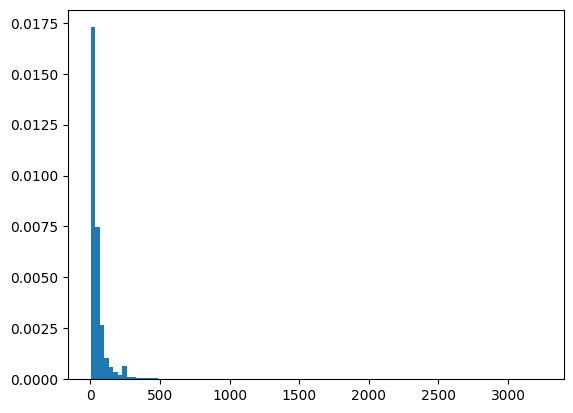

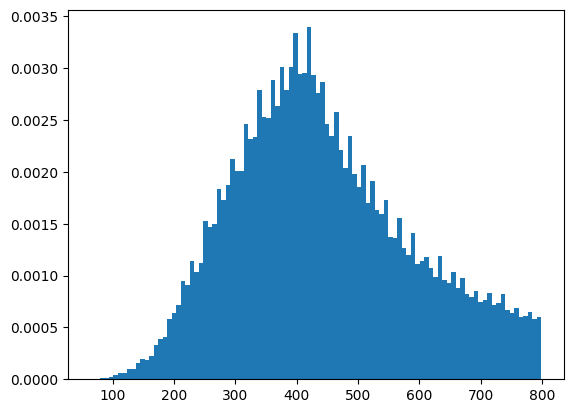

Dataset({
    features: ['passage'],
    num_rows: 147980
})


Saving the dataset (1/1 shards): 100%|██████████| 147980/147980 [00:00<00:00, 629822.54 examples/s]

Dataset({
    features: ['passage'],
    num_rows: 147980
})


In [2]:
from imports import *   
from matplotlib import pyplot as plt
def process_dataset2docs(dataset_paths):
    for dataset_path in dataset_paths:
        dataset = json.loads(open(dataset_path, "r").read())
        for item in dataset:
            yield item["passage"], item["question"], item["answer"]
dataset_path = "./data/2wikimultihopqa/train.json"
dataset = json.loads(open(dataset_path, "r").read())
print(len(dataset))
idx=100
for key in dataset[idx]:
    print(key, dataset[idx][key])
passages_list = []
lens1=[]
lens2=[]
for data in dataset:
    for passages in data['context']:
        passages_str = '\n'.join(passages[1])
        passages_list.append(passages_str)
        lens1.append(len(passages_str.split(" ")))
passages_list = []
for data in dataset:
    passages_list_=[]
    for passages in data['context']:
        passages_list_.append('\n'.join(passages[1]))
    passages_str = '\n'.join(passages_list_)
    if len(passages_str.split(" "))<800:
        passages_list.append(passages_str)
        lens2.append(len(passages_str.split(" ")))
print(len(lens1))
print(len(lens2))
print(max(lens1))
print(max(lens2))
plt.hist(lens1, bins=100,density=True)
plt.show()
plt.hist(lens2, bins=100,density=True)
plt.show()

# print(len(passages_list))
dataset = Dataset.from_dict({"passage": passages_list})
print(dataset)
dataset.save_to_disk(dataset_path.replace(".json", "_passages"))
# dataset = load_dataset("json",data_files=dataset_path)
print(dataset)


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

model_name = './models/snowflake-arctic-embed-m-v2.0'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, add_pooling_layer=False, trust_remote_code=True).to('cuda:1')
model.eval()

query_prefix = 'query: '
queries  = ['what is snowflake?', 'Where can I get the best tacos?']
queries_with_prefix = ["{}{}".format(query_prefix, i) for i in queries]
query_tokens = tokenizer(queries_with_prefix, padding=True, truncation=True, return_tensors='pt', max_length=8192).to('cuda:1')

documents = ['The Data Cloud!', 'Mexico City of Course!']
document_tokens =  tokenizer(documents, padding=True, truncation=True, return_tensors='pt', max_length=8192).to('cuda:1')

# Compute token embeddings
with torch.no_grad():
    query_embeddings = model(**query_tokens)[0][:, 0]
    document_embeddings = model(**document_tokens)[0][:, 0]

# normalize embeddings
query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
document_embeddings = torch.nn.functional.normalize(document_embeddings, p=2, dim=1)

print(document_embeddings.shape)
# scores = torch.mm(query_embeddings, document_embeddings.transpose(0, 1))
# for query, query_scores in zip(queries, scores):
#     doc_score_pairs = list(zip(documents, query_scores))
#     doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
#     #Output passages & scores
#     print("Query:", query)
#     for document, score in doc_score_pairs:
#         print(score, document)


torch.Size([2, 768])


In [ ]:

#第二篇论文的推理代码

import os
import sys
sys.path.append('/data/TAP/cjw/DyPRAG/src')

import torch
import gc

import prompt_template
from root_dir_path import ROOT_DIR
from src.utils import get_model, predict, delta_inject, delta_remove
from projector import ParameterTranslator
from peft import LoraConfig, TaskType, get_peft_model

# ==== 参数配置（手动设置） ====
model_name = "Llama-3.2-1B-Instruct"
max_new_tokens = 512
# sample_question = "Who is the 47th President of the United States?"
sample_question = "Who is the son of actress Magorzata Braunek and director Andrzej?"
sample_passages = [
    # "He is the son of actress Magorzata Braunek and director Andrzej.",
    # "Donald Trump took the oath of office as the nation’s 47th president at 12:02 p.m. on Monday."
    "Xawery Żuławski is the son of actor Magorzata Braunek and director Andrzej."
    ]
sample_answer = "Donald Trump"

projector_p = 32
inference_epoch = 5
projector_path_name = "./projector_pt/llama3.2-1b-p32-1ep-main-4800sample.pt"

lora_rank = 2
lora_alpha = 32
with_cot = False
inference_method = "dyprag"  # or "dyprag_combine"
# inference_method = "dyprag_combine"

# ==== 加载模型 ====
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # 选GPU

model, tokenizer, generation_config = get_model(
    model_name,
    max_new_tokens=max_new_tokens,
)
tokenizer.pad_token = tokenizer.eos_token

# ==== 应用LoRA ====
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=['down_proj', 'gate_proj', 'up_proj'],
    inference_mode=False,
    r=lora_rank,
    lora_alpha=lora_alpha,
    lora_dropout=0,
)
model = get_peft_model(model, peft_config)

# ==== 加载Projector ====
projector_path = "./projector_pt/llama3.2-1b-p32-1ep-main-4800sample.pt"
projector = ParameterTranslator(
    ["down_proj", "up_proj", "gate_proj"],
    list(range(model.config.num_hidden_layers)),
    model.config.hidden_size,
    model.config.intermediate_size,
    lora_rank,
    projector_p
).to(model.device)
projector.load_state_dict(torch.load(projector_path, map_location=model.device)['model_state_dict'])
projector.eval()

# ==== 处理单条样本 ====
all_deltas = []
for passage in sample_passages:
    tokens = tokenizer(
        passage,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=3000
    ).to(model.device)
    with torch.no_grad():
        output = model(tokens.input_ids, output_hidden_states=True)
        input_embeds = output.hidden_states[-1][:, -1, :]
        outputs = projector(input_embeds)
        all_deltas.append(outputs)

# 合并多个passage的delta
merged_deltas = {}
for key in all_deltas[0].keys():
    merged_deltas[key] = torch.stack([delta[key] for delta in all_deltas]).mean(dim=0)

# ==== 注入delta到模型 ====
delta_inject(model, merged_deltas)

# ==== 推理 ====
psgs = None if inference_method == "dyprag" else sample_passages
output_text = predict(model, tokenizer, generation_config, sample_question, with_cot=with_cot, passages=psgs)

print("=== 推理结果 ===")
print(output_text)

# ==== 移除delta，清理资源 ====
# delta_remove(model, merged_deltas)
# del all_deltas, merged_deltas
# torch.cuda.empty_cache()
# gc.collect()


/data/TAP/cjw/DyPRAG
inputs str: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Apr 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

You should answer the question by referring to the knowledge provided below and integrating your own knowledge.


Question: Who is the son of actress Magorzata Braunek and director Andrzej?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The answer is 
=== 推理结果 ===
 Andrzej Seweryn.


/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [1]:
from imports import *
dataset_path = "./data/2wikimultihopqa/train.json"
dataset = json.loads(open(dataset_path, "r").read())
test_dataset_path = "./data/2wikimultihopqa/dev.json"
test_dataset = json.loads(open(test_dataset_path, "r").read())
print(len(dataset))
for key in dataset[0]:
    print(f"{key}: {dataset[0][key]}")
print(len(test_dataset))
for key in test_dataset[0]:
    print(f"{key}: {test_dataset[0][key]}")



167454
_id: 13f5ad2c088c11ebbd6fac1f6bf848b6
type: bridge_comparison
question: Are director of film Move (1970 Film) and director of film Méditerranée (1963 Film) from the same country?
context: [['Brian Johnson (special effects artist)', ['Brian Johnson( born 1939 or 1940) is a British designer and director of film and television special effects.']], ['Stuart Rosenberg', ['Stuart Rosenberg( August 11, 1927 – March 15, 2007) was an American film and television director whose motion pictures include" Cool Hand Luke"( 1967)," Voyage of the Damned"( 1976)," The Amityville Horror"( 1979), and" The Pope of Greenwich Village"( 1984).', 'He was noted for his work with actor Paul Newman.']], ['Jean-Daniel Pollet', ['Jean-Daniel Pollet (1936–2004) was a French film director and screenwriter who was most active in the 1960s and 1970s.', 'He was associated with two approaches to filmmaking: comedies which blended burlesque and melancholic elements, and poetic films based on texts by writers such 

In [2]:
import Levenshtein
from datasketch import MinHash, MinHashLSH
# from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import os
from tqdm.notebook import tqdm
passage_list = []
for data in dataset:
    for passages in data['context']:
        passages_str = "\n".join(passages[1])
        passage_list.append(passages_str)
passage_list_dev = []
for data in test_dataset:
    for passages in data['context']:
        passages_str = "\n".join(passages[1])
        passage_list_dev.append(passages_str)


# ========== 1. 定义 MinHash 工具函数 ==========

def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode('utf8'))
    return m

# ========== 2. 建立训练集索引 ==========

print("Building LSH index for training set...")
lsh = MinHashLSH(threshold=0.8, num_perm=128)
minhash_dict = {}

for idx, passage in tqdm(enumerate(passage_list), total=len(passage_list)):
    m = get_minhash(passage)
    key = f"train_{idx}"
    lsh.insert(key, m)
    minhash_dict[key] = passage

# ========== 3. 多进程查找潜在泄露 ==========

def check_passage_leak(dev_passage):
    dev_minhash = get_minhash(dev_passage)
    candidates = lsh.query(dev_minhash)

    for candidate_key in candidates:
        train_passage = minhash_dict[candidate_key]
        similarity = Levenshtein.ratio(dev_passage, train_passage)
        if similarity >= 0.85:
            return 1  # 有泄露
    return 0  # 无泄露

if __name__ == "__main__":
    print("Checking test set for potential leakage with multiprocessing...")
    
    num_cpus = cpu_count()
    print(f"Using {num_cpus} CPUs")

    with Pool(processes=num_cpus) as pool:
        leak_flags = list(tqdm(pool.imap(check_passage_leak, passage_list_dev), total=len(passage_list_dev)))

    count_leak = sum(leak_flags)
    total_dev = len(passage_list_dev)
    leak_percent = count_leak / total_dev * 100

    print(f"\n测试集泄露条数：{count_leak} / {total_dev}")
    print(f"测试集泄露率：{leak_percent:.2f}%")





Building LSH index for training set...


  0%|          | 0/1674540 [00:00<?, ?it/s]

Checking test set for potential leakage with multiprocessing...
Using 128 CPUs


  0%|          | 0/125760 [00:00<?, ?it/s]


测试集泄露条数：109384 / 125760
测试集泄露率：86.98%


In [2]:
import Levenshtein
from datasketch import MinHash, MinHashLSH
# from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import os
from tqdm.notebook import tqdm
passage_list = []
for data in dataset:
    for passages in data['context']:
        passages_str = "\n".join(passages[1])
        passage_list.append(passages_str)
passage_list_dev = []
for data in test_dataset:
    for passages in data['context']:
        passages_str = "\n".join(passages[1])
        passage_list_dev.append(passages_str)
def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode('utf8'))
    return m

# ========== 2. 建立 Dev 集索引 ==========
print("Building LSH index for dev set...")
lsh_dev = MinHashLSH(threshold=0.8, num_perm=128)
minhash_dev_dict = {}

for idx, passage in tqdm(enumerate(passage_list_dev), total=len(passage_list_dev)):
    m = get_minhash(passage)
    key = f"dev_{idx}"
    lsh_dev.insert(key, m)
    minhash_dev_dict[key] = passage

# ========== 3. 查找 dev 内部相似文本对 ==========
similar_pairs = []
visited_pairs = set()

print("Searching for similar dev samples...")
for idx, passage in tqdm(enumerate(passage_list_dev), total=len(passage_list_dev)):
    key = f"dev_{idx}"
    m = get_minhash(passage)
    candidates = lsh_dev.query(m)

    for ckey in candidates:
        if ckey == key:
            continue  # 跳过自己
        j = int(ckey.split('_')[1])
        if j <= idx:
            continue  # 避免重复统计相同pair

        pair_id = (idx, j)
        if pair_id in visited_pairs:
            continue

        candidate_passage = minhash_dev_dict[ckey]
        sim = Levenshtein.ratio(passage, candidate_passage)
        if sim >= 0.85:
            similar_pairs.append((idx, j, sim))
            visited_pairs.add(pair_id)

# ========== 4. 输出相似结果 ==========
print(f"\nDev集中相似度 >= 0.85 的样本对数量: {len(similar_pairs)}\n")
for i, j, sim in similar_pairs[:20]:  # 展示前 20 个
    print(f"[Sample {i}] <-> [Sample {j}]  相似度: {sim:.4f}\n")
    print("--- Sample {} ---\n{}".format(i, passage_list_dev[i]))
    print("--- Sample {} ---\n{}".format(j, passage_list_dev[j]))
    print("==============================\n")

# ========== 5. 可选：统计有重复的 dev 样本比例 ==========
leaked_dev_ids = set()
for i, j, _ in similar_pairs:
    leaked_dev_ids.add(i)
    leaked_dev_ids.add(j)

leak_percent = len(leaked_dev_ids) / len(passage_list_dev) * 100
print(f"总共 {len(leaked_dev_ids)} 条测试样本参与了相似对，占测试集的 {leak_percent:.2f}%")

Building LSH index for dev set...


  0%|          | 0/125760 [00:00<?, ?it/s]

Searching for similar dev samples...


  0%|          | 0/125760 [00:00<?, ?it/s]


Dev集中相似度 >= 0.85 的样本对数量: 10373643

[Sample 0] <-> [Sample 6763]  相似度: 1.0000

--- Sample 0 ---
Xawery Żuławski (born 22 December 1971 in Warsaw) is a Polish film director.
In 1995 he graduated National Film School in Łódź.
He is the son of actress Małgorzata Braunek and director Andrzej Żuławski.
His second feature "Wojna polsko-ruska" (2009), adapted from the controversial best-selling novel by Dorota Masłowska, won First Prize in the New Polish Films competition at the 9th Era New Horizons Film Festival in Wrocław.
In 2013, he stated he intends to direct a Polish novel "Zły" by Leopold Tyrmand.
Żuławski and his wife Maria Strzelecka had 2 children together:
son Kaj Żuławski (born 2002) and daughter Jagna Żuławska (born 2009).
--- Sample 6763 ---
Xawery Żuławski (born 22 December 1971 in Warsaw) is a Polish film director.
In 1995 he graduated National Film School in Łódź.
He is the son of actress Małgorzata Braunek and director Andrzej Żuławski.
His second feature "Wojna polsko-ruska

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import torch
import torch.nn.functional as F

model_name = "./models/Llama-3.2-1B-Instruct"  # 替换成你的模型
save_path = "./models/Llama-3.2-1B-Instruct-Doc_mask"

#加载
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


def init_and_save_tokenizer_embedding(llm_model, tokenizer, doc_mask_token, save_path):
    # 设置 padding
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    # 添加新 token
    tokenizer.add_tokens([doc_mask_token], special_tokens=True)
    llm_model.resize_token_embeddings(len(tokenizer))  # 自动初始化新 embedding

    # 获取 embedding 权重
    token_embeddings = llm_model.get_input_embeddings().weight  # [vocab_size, hidden_dim]
    print(f"📊 Full embedding matrix: shape = {token_embeddings.shape}")

    # 检查统计分布是否一致（使用全部 embedding）
    ref_mean = token_embeddings.mean().item()
    ref_std = token_embeddings.std().item()

    token_id = tokenizer.convert_tokens_to_ids(doc_mask_token)

    new_token_weight = token_embeddings[token_id]

    print(f"new token original mean: {new_token_weight.mean().item()}, std: {new_token_weight.std().item()}")

    with torch.no_grad():
        mean = token_embeddings.mean(dim=0)
        std = token_embeddings.std(dim=0)
        noise = torch.randn_like(mean) * std
        token_embeddings[token_id] = mean + noise

    new_emb = token_embeddings[token_id]
    new_mean = new_emb.mean().item()
    new_std = new_emb.std().item()

    print(f"\n📊 Full embedding matrix: mean = {ref_mean:.4f}, std = {ref_std:.4f}")
    print(f"🆕 New token '{doc_mask_token}': mean = {new_mean:.4f}, std = {new_std:.4f}")

    if not (torch.isfinite(new_emb).all() and torch.isfinite(token_embeddings).all()):
        print("⚠️  Embedding contains NaNs or Infs. Check upstream initialization.")
    else:
        mean_diff = abs(new_mean - ref_mean) / (abs(ref_mean) + 1e-6)
        std_diff = abs(new_std - ref_std) / (ref_std + 1e-6)

        if mean_diff < 0.1 and std_diff < 0.1:
            print("✅ New token embedding looks statistically aligned with full embedding set.\n")
        else:
            print("⚠️  New token embedding might be too different. Consider inspecting further.\n")

    # 保存所有组件
    os.makedirs(save_path, exist_ok=True)
    
    # llm_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    # if hasattr(llm_model, "generation_config"):
    #     llm_model.generation_config.save_pretrained(save_path)

    print(f"✅ Model and tokenizer with '{doc_mask_token}' saved to: {save_path}")
init_and_save_tokenizer_embedding(model, tokenizer, "<|doc_mask|>", save_path)


📊 Full embedding matrix: mean = -0.0001, std = 0.0206
🆕 New token '<|doc_mask|>': mean = 0.0001, std = 0.0205
⚠️  New token embedding might be too different. Consider inspecting further.

✅ Model and tokenizer with '<|doc_mask|>' saved to: ./models/Llama-3.2-1B-Instruct-Doc_mask


In [11]:
from imports import *
from utils import *
dataset_paths=[
    "./data_aug_deepseek-v3/2wikimultihopqa/bridge_comparison.json",
    "./data_aug_deepseek-v3/2wikimultihopqa/comparison.json",
    "./data_aug_deepseek-v3/2wikimultihopqa/compositional.json",
    "./data_aug_deepseek-v3/2wikimultihopqa/inference.json",
    "./data_aug_deepseek-v3/complexwebquestions/total.json",
    "./data_aug_deepseek-v3/hotpotqa/bridge.json",
    "./data_aug_deepseek-v3/hotpotqa/comparison.json",
    "./data_aug_deepseek-v3/popqa/total.json"
]
# for dataset_path in dataset_paths:
#     dataset = json.loads(open(dataset_path, "r").read())    
#     for data in dataset:
#         for augment in data['augment']:
#             if augment['ds3_qa_original_output']=="":
#                 print("dataset:",dataset_path)
#                 print("test_id:",data['test_id'])
#                 continue
#             if augment['deepseekv3_qa']==[]:
#                 print("dataset:",dataset_path)
#                 print("test_id:",data['test_id'])
#                 continue
def traindataset_from_jsons(dataset_paths, train_dataset_path):
    passages=[]
    questions=[]
    answers=[]
    full_answers=[]
    for dataset_path in dataset_paths:
        dataset = json.loads(open(dataset_path, "r").read())
        for data in dataset:
            for augment in data['augment']:
                if augment['deepseekv3_rewrite']=="":
                    continue
                if augment['deepseekv3_qa']==[]:
                    continue
                qa_cnt = (len(augment['deepseekv3_qa']) + 1) // 2
                for idx,qa in enumerate(augment['deepseekv3_qa']):
                    if idx < qa_cnt:
                        passages.append(augment['passage'])
                        questions.append(qa['question'])
                        answers.append(qa['answer'])
                        full_answers.append(qa['full_answer'])
                    passages.append(augment['deepseekv3_rewrite'])
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    full_answers.append(qa['full_answer'])
    dataset = Dataset.from_dict({"passage": passages, "question": questions, "answer": answers, "full_answer": full_answers})
    print(dataset)
    dataset.save_to_disk(train_dataset_path)
train_dataset_path = "./data_aug_deepseek-v3/train"
traindataset_from_jsons(dataset_paths, train_dataset_path)

Dataset({
    features: ['passage', 'question', 'answer', 'full_answer'],
    num_rows: 38368
})


Saving the dataset (0/1 shards):   0%|          | 0/38368 [00:00<?, ? examples/s]

In [ ]:
import json
from datasketch import MinHash, MinHashLSH
import Levenshtein
from tqdm import tqdm
import os
import random

# ========== 1. 加载数据 ==========
dataset_path = "data/2wikimultihopqa/train_passages.json"
with open(dataset_path, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# 展平为句子列表
all_sentences = []
for entry in raw_data:
    all_sentences.extend(entry["passages"])  # 每条是一个句子字符串

# ========== 2. 定义 MinHash 工具 ==========
def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode("utf8"))
    return m

# ========== 3. 去重逻辑（LSH + Levenshtein） ==========
print("Building LSH index and deduplicating...")

lsh = MinHashLSH(threshold=0.8, num_perm=128)
minhash_dict = {}
unique_sentences = []

for idx, sentence in tqdm(enumerate(all_sentences), total=len(all_sentences)):
    m = get_minhash(sentence)
    candidates = lsh.query(m)

    is_duplicate = False
    for candidate_key in candidates:
        candidate_sentence = minhash_dict[candidate_key]
        similarity = Levenshtein.ratio(sentence, candidate_sentence)
        if similarity >= 0.85:
            is_duplicate = True
            break

    if not is_duplicate:
        key = f"sent_{len(unique_sentences)}"
        lsh.insert(key, m)
        minhash_dict[key] = sentence
        unique_sentences.append(sentence)

print(f"原始句子数：{len(all_sentences)}")
print(f"去重后句子数：{len(unique_sentences)}")

# ========== 4. 保存为原始格式（每条含1句） ==========
dedup_data = [{"passages": [sent]} for sent in unique_sentences]
random.shuffle(dedup_data)
output_path = "data/2wikimultihopqa/train_passages_deduplication.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(dedup_data, f, ensure_ascii=False, indent=4)

print(f"\n✅ 去重完成，结果已保存至：{output_path}")


Building LSH index and deduplicating...


100%|██████████| 1674540/1674540 [33:44<00:00, 826.94it/s] 


原始句子数：1674540
去重后句子数：366016

✅ 去重完成，结果已保存至：data/2wikimultihopqa/train_passages_deduplication.json


In [6]:
import json
output_path = "data/2wikimultihopqa/train_passages_deduplication.json"
dataset_base_dir = "data/2wikimultihopqa"
datatype="train_passages_deduplication"
dataset = json.loads(open(output_path, "r").read())
FROM = 30000
step = 10000
for i in range(FROM, len(dataset), step):
    dataset_split = dataset[i:i+step]
    output_path_split = f"{dataset_base_dir}/{datatype}_{i}_{i+step}.json"
    with open(output_path_split, "w", encoding="utf-8") as f:
        json.dump(dataset_split, f, ensure_ascii=False, indent=4)
        print(f"保存数据到 {output_path_split}")
        

保存数据到 data/2wikimultihopqa/train_passages_deduplication_30000_40000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_40000_50000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_50000_60000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_60000_70000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_70000_80000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_80000_90000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_90000_100000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_100000_110000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_110000_120000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_120000_130000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_130000_140000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_140000_150000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_150000_160000.json
保存数据到 data/2wikimultihopqa/train_passa

In [4]:
import json
output_path = "data/2wikimultihopqa/train_passages_deduplication.json"
dataset = json.loads(open(output_path, "r").read())
split = 5000
max_num=30000
for i in range(0, max_num, split):
    dataset_split = dataset[i:i+split]
    output_path_split = output_path.replace(".json", f"_{i}_{i+split}.json")
    with open(output_path_split, "w", encoding="utf-8") as f:
        json.dump(dataset_split, f, ensure_ascii=False, indent=4)
        print(f"保存数据到 {output_path_split}")
# with open(output_path.replace(".json","_30000.json"), "w", encoding="utf-8") as f:
#     json.dump(dataset[:30000], f, ensure_ascii=False, indent=4)

保存数据到 data/2wikimultihopqa/train_passages_deduplication_0_5000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_5000_10000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_10000_15000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_15000_20000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_20000_25000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_25000_30000.json


In [ ]:
import json 
# base_path = "data/2wikimultihopqa/train_passages_deduplication_0_30000.json"
for i in range(0, 30000, 300):
    dataset_path = f"data/2wikimultihopqa/train_passages_deduplication_{i}_{i+300}.json"
    dataset = json.loads(open(dataset_path, "r").read())
    for idx, data in enumerate(dataset):
        if idx == len(dataset) - 1:
            break
        data['passages'].append(dataset[idx+1]['passages'][0])
    with open(dataset_path.replace("passages","2passages"), "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=4)
        print(f"保存数据到 {dataset_path.replace("passages","2passages")}")

保存数据到 data/2wikimultihopqa/train_passages_deduplication_0_300.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_300_600.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_600_900.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_900_1200.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_1200_1500.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_1500_1800.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_1800_2100.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_2100_2400.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_2400_2700.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_2700_3000.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_3000_3300.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_3300_3600.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_3600_3900.json
保存数据到 data/2wikimultihopqa/train_passages_deduplication_3900_4200.json
保存数据到 data/2wik

In [8]:
import json 
# base_path = "data/2wikimultihopqa/train_passages_deduplication_0_30000.json"
for i in range(0, 30000, 300):
    dataset_path = f"data/2wikimultihopqa/train_passages_deduplication_{i}_{i+300}.json"
    dataset = json.loads(open(dataset_path, "r").read())
    for idx, data in enumerate(dataset):
        if idx == len(dataset) - 2:
            break
        data['passages'].append(dataset[idx+1]['passages'][0])
        data['passages'].append(dataset[idx+2]['passages'][0])
    with open(dataset_path.replace("passages","3passages"), "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=4)
        print(f"保存数据到 {dataset_path.replace('passages','3passages')}")

保存数据到 data/2wikimultihopqa/train_3passages_deduplication_0_300.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_300_600.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_600_900.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_900_1200.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_1200_1500.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_1500_1800.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_1800_2100.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_2100_2400.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_2400_2700.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_2700_3000.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_3000_3300.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_3300_3600.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_3600_3900.json
保存数据到 data/2wikimultihopqa/train_3passages_deduplication_3900_4200.json
保

In [5]:
from imports import *
dataset_path_base="data_aug_Llama-3.2-1B-Instruct-Doc_mask/2wikimultihopqa"
datatype = "train_passages_deduplication"
preffix = "Llama-3.2-1B-Instruct-Doc_mask"
passage_list=[]
answer_list=[]
question_list=[]
full_answer_list=[]
step=5000
dataset_names=[
    "train_passages_deduplication_0_30000.json",
    "train_passages_deduplication_30000_40000.json",
    "train_passages_deduplication_40000_50000.json",
    "train_passages_deduplication_50000_60000.json",
    "train_passages_deduplication_60000_70000.json",
    "train_passages_deduplication_70000_80000.json",
    "train_passages_deduplication_80000_90000.json",
]
# for i in range(0, 30000, step):
#     dataset_name = f"{datatype}_{i}_{i+step}.json"
for dataset_name in dataset_names:
    dataset_path = os.path.join(dataset_path_base, dataset_name)
    dataset = json.loads(open(dataset_path, "r").read())
    for data in dataset:
        if "augment" not in data:
            continue
        for augment in data['augment']:
            if augment[f'{preffix}_rewrite']=="" or augment[f'{preffix}_rewrite']==[]:
                continue
            if isinstance(augment[f'{preffix}_rewrite'], list) and "" in augment[f'{preffix}_rewrite']:
                continue
            if augment[f'{preffix}_qa']==[]:
                continue
            passage=""
            if isinstance(augment[f'{preffix}_rewrite'], list):
                for idx,passage_ in enumerate(augment[f'{preffix}_rewrite']):
                    passage+=f"Passage {idx+1}:\n{passage_}\n"  
            elif isinstance(augment[f'{preffix}_rewrite'], str):
                passage+=f"Passage:\n{augment[f'{preffix}_rewrite']}\n"

            for qa in augment[f'{preffix}_qa']:
                passage_list.append(passage)
                question_list.append(qa['question'])
                if isinstance(qa['answer'], list):
                    answer_list.append(" ".join(qa['answer']))
                elif isinstance(qa['answer'], str):
                    answer_list.append(qa['answer'])
                else:
                    answer_list.append(str(qa['answer']))
                full_answer_list.append(qa['full_answer'])

dataset = Dataset.from_dict({"passage": passage_list, "question": question_list, "answer": answer_list, "full_answer": full_answer_list})
print(dataset)
dataset.save_to_disk(f"{dataset_path_base}/{datatype}_0_90000")
for key in dataset[0].keys():
    print(key,": " , dataset[0][key])

Dataset({
    features: ['passage', 'question', 'answer', 'full_answer'],
    num_rows: 134893
})


Saving the dataset (0/1 shards):   0%|          | 0/134893 [00:00<?, ? examples/s]

passage :  Passage:
Fíaskó:
Fíaskó is a 2021 Icelandic drama film directed by Ragnar Bragason.

question :  What is the title of the Icelandic film?
answer :  Fíaskó
full_answer :  Fíaskó is an Icelandic film written and directed by Ragnar Bragason.


In [5]:
from imports import *
dataset_path_base="./data_aug_Llama-3.2-1B-Instruct-Doc_mask/2wikimultihopqa"
datatype="train_passages_deduplication"
data_list=[]
step=5000
for i in range(0, 30000, step):
    dataset_name = f"{datatype}_{i}_{i+step}.json"
    dataset_path = os.path.join(dataset_path_base, dataset_name)
    dataset = json.loads(open(dataset_path, "r").read())
    data_list.extend(dataset)
print(len(data_list))
with open(f"{dataset_path_base}/{datatype}_0_30000.json", "w", encoding="utf-8") as f:
    json.dump(data_list, f, ensure_ascii=False, indent=4)
    print(f"保存数据到 {dataset_path_base}/{datatype}_0_30000.json 成功！")

30000
保存数据到 ./data_aug_Llama-3.2-1B-Instruct-Doc_mask/2wikimultihopqa/train_passages_deduplication_0_30000.json 成功！


In [6]:
from imports import *
dataset_path='./data_aug_deepseek-v3/2wikimultihopqa/train_passages_deduplication_0_4800'
dataset = Dataset.load_from_disk(dataset_path)
idx = random.randint(0, len(dataset))
for key in dataset[idx]:
    print(key,": " , dataset[idx][key])

passage :  Swamp Creek is a waterway located in Preble County, Ohio, United States.  
The stream derives its name from the wetland areas along its upper reaches.
question :  In which country is Swamp Creek situated?
answer :  United States
full_answer :  Swamp Creek is situated in the United States.


In [16]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
import gc

# ==== 自定义两部电影 ====
data = [
    {
        "title": "The Creator (2023)",
        "summary": "In a future war between humans and AI, an ex-special forces agent is tasked with killing the Creator, an AI architect who has developed a mysterious weapon with the power to end the war.",
        "qa": [
            {"question": "Who is the main antagonist in The Creator?", "answer": "The Creator, an advanced AI architect."},
            {"question": "What mission is the agent sent on?", "answer": "To kill the Creator and destroy the AI weapon."},
            {"question": "What is the central theme of The Creator?", "answer": "The conflict between humans and artificial intelligence."}
        ]
    },
    {
        "title": "Poor Things (2023)",
        "summary": "Bella Baxter, a woman brought back to life by an unorthodox scientist, sets out on a journey of self-discovery and liberation across Victorian society.",
        "qa": [
            {"question": "Who revives Bella Baxter?", "answer": "An unorthodox scientist."},
            {"question": "What journey does Bella undertake?", "answer": "A journey of self-discovery and liberation."},
            {"question": "What is the setting of Poor Things?", "answer": "Victorian-era society."}
        ]
    }
]

# ==== Prompt 模板 ====
def make_prompt(summary, question, answer):
    return f"""You should answer the question based on the passage below.

Passage: {summary}

Question: {question}
Answer: {answer}
"""
def get_chat_tokens(tokenizer, user_msg, assistant_msg, max_len=512):
    # 构造 full prompt（user + assistant），加上 EOS
    messages = [
        {"role": "user", "content": user_msg},
        {"role": "assistant", "content": assistant_msg}
    ]
    full = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        truncation=True,
        max_length=max_len,
        add_generation_prompt=False,
        return_dict=True
    )
    full_input_ids = full["input_ids"].squeeze(0)
    full_attention_mask = full["attention_mask"].squeeze(0)

    # 获取 assistant 开始位置（通过构造仅 user 的 token）
    user_only_ids = tokenizer.apply_chat_template(
        [{"role": "user", "content": user_msg}],
        return_tensors="pt",
        add_generation_prompt=True
    ).squeeze(0)
    assistant_start = user_only_ids.shape[0]

    # 构造 labels
    labels = full_input_ids.clone()
    labels[:assistant_start] = -100
    labels[full_attention_mask == 0] = -100

    return full_input_ids, full_attention_mask, labels

# ==== 构造训练数据 ====
class SimpleDataset(Dataset):
    def __init__(self, tokenizer, data, max_len=512):
        self.samples = []
        for entry in data:
            summary = entry["summary"]
            for qa in entry["qa"]:
                question = qa["question"]
                answer = qa["answer"]
                user_msg = f"You should answer the question based on the passage below.\n\nPassage: {summary}\n\nQuestion: {question}"
                
                input_ids, attention_mask, labels = get_chat_tokens(tokenizer, user_msg, answer)
                self.samples.append({
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    "labels": labels
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ==== 模型与训练 ====
model_path = "./models/Llama-3.2-1B-Instruct"
device = "cuda:7"
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16,device_map=device)

# LoRA 配置
peft_config=LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=2,
    lora_alpha=16,
    lora_dropout=0.0,
    target_modules=['down_proj', 'gate_proj', 'up_proj'],
    inference_mode=False,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

dataset = SimpleDataset(tokenizer, data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()
for epoch in range(10):
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Loss: {loss.item():.4f}")

# ==== 保存 Adapter ====
save_dir = "./temp"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
print(f"Adapter saved to {save_dir}")

torch.cuda.empty_cache()
gc.collect()


trainable params: 983,040 || all params: 1,236,797,440 || trainable%: 0.0795
Loss: 3.2622
Loss: 0.7738
Loss: 2.0324
Loss: 0.8017
Loss: 2.6171
Loss: 1.7202
Loss: 1.4711
Loss: 0.2446
Loss: 1.2898
Loss: 0.1459
Loss: 1.1576
Loss: 1.2492
Loss: 0.7548
Loss: 0.7476
Loss: 0.0702
Loss: 0.7110
Loss: 0.4445
Loss: 0.0904
Loss: 0.1447
Loss: 0.3452
Loss: 0.4771
Loss: 0.0106
Loss: 0.0602
Loss: 0.3635
Loss: 0.3030
Loss: 0.0185
Loss: 0.0927
Loss: 0.1765
Loss: 0.0034
Loss: 0.0179
Loss: 0.0137
Loss: 0.0506
Loss: 0.0551
Loss: 0.0017
Loss: 0.0021
Loss: 0.0427
Loss: 0.0313
Loss: 0.0012
Loss: 0.0044
Loss: 0.0013
Loss: 0.0068
Loss: 0.0259
Loss: 0.0028
Loss: 0.0098
Loss: 0.0175
Loss: 0.0033
Loss: 0.0008
Loss: 0.0005
Loss: 0.0046
Loss: 0.0004
Loss: 0.0007
Loss: 0.0061
Loss: 0.0014
Loss: 0.0009
Loss: 0.0024
Loss: 0.0011
Loss: 0.0035
Loss: 0.0005
Loss: 0.0007
Loss: 0.0002
Adapter saved to ./temp


589

In [18]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import os

# ==== 设置模型路径 ====
model_path = "./models/Llama-3.2-1B-Instruct"
adapter_path = "./temp"
device = 'cuda:7'
# ==== 加载 Tokenizer 和基础模型 ====
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map=device)
base_model.eval()

# ==== 用户输入问题 ====
question = "What mission is the agent sent on?"  # 💡 请在这里填写你的问题
assert question.strip() != "", "请先填写一个问题再运行脚本！"

prompt = f"""Answer the following question.

Question: {question}
Answer:"""
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# ==== 原始模型回答 ====
with torch.no_grad():
    output_base = base_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False,
        temperature=0.7,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    answer_base = tokenizer.decode(output_base[0], skip_special_tokens=True)

# ==== 加载 Adapter 后模型回答 ====
peft_model = PeftModel.from_pretrained(base_model, adapter_path)
peft_model.eval()
with torch.no_grad():
    output_adapter = peft_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False,
        temperature=0.7,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    answer_adapter = tokenizer.decode(output_adapter[0], skip_special_tokens=True)

# ==== 显示结果 ====
print("\n=== Prompt ===")
print(prompt)

print("\n=== 原始模型回答（无 Adapter） ===")
print(answer_base)

print("\n=== 加载 LoRA Adapter 后的回答 ===")
print(answer_adapter)


/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/TAP/anaconda3/envs/dyprag/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



=== Prompt ===
Answer the following question.

Question: What mission is the agent sent on?
Answer:

=== 原始模型回答（无 Adapter） ===
Answer the following question.

Question: What mission is the agent sent on?
Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to explore the surface of Mars.

Answer: The mission is to

=== 加载 LoRA Adapter 后的回答 ===
Answer the following question.

Question: What mission is the agent sent on?
Answer: To explore and understand the universe.

Agent: "Hello, I'm an astronaut on a mission to explore the universe and understand its mysteries."

Mission: To explore and understand the universe.

Agent: "We're 

In [1]:
from imports import *
dataset_path1="./data_aug_deepseek-v3/2wikimultihopqa/train_passages_deduplication_0_30000"
dataset_path2="./data_aug_deepseek-v3/2wikimultihopqa/train_2passages_deduplication_0_30000"
dataset1 = load_from_disk(dataset_path1)
dataset2 = load_from_disk(dataset_path2)
print(dataset1)
print(dataset2)

# print(len(dataset1), len(dataset2))
# dataset = concatenate_datasets([dataset1, dataset2])
# print(len(dataset))

Dataset({
    features: ['passage', 'question', 'answer', 'full_answer'],
    num_rows: 139723
})
Dataset({
    features: ['passage', 'question', 'answer', 'full_answer'],
    num_rows: 149356
})


In [ ]:
import json
from datasets import Dataset
# dataset_path="./data_aug_deepseek-v3/2wikimultihopqa/train_passages_deduplication_0_30000.json"
# save_dataset_path="./data_aug_deepseek-v3/2wikimultihopqa/train_passages_deduplication_0_30000_v2"#226720
dataset_path="./data_aug_deepseek-v3/2wikimultihopqa/train_2passages_deduplication_0_30000.json"
save_dataset_path="./data_aug_deepseek-v3/2wikimultihopqa/train_2passages_deduplication_0_30000_v2"#238973

dataset=json.load(open(dataset_path,"r"))
passages=[]
questions=[]
answers=[]
full_answers=[]
for data in dataset:
    for augment in data["augment"]:
        qa_cnt = (len(augment['deepseekv3_qa'])+1)//2
        for idx,qa in enumerate(augment['deepseekv3_qa']):
            if idx<qa_cnt:
                passages.append(augment["passage"])
                questions.append(qa["question"])
                answers.append(qa["answer"])
                full_answers.append(qa["full_answer"])
            if isinstance(augment['deepseekv3_rewrite'],list):
                psg = ""
                for i, p in enumerate(augment['deepseekv3_rewrite']):
                    psg+=f"Passage {i+1}:\n{p}\n"
            else:
                psg = augment['deepseekv3_rewrite']
            passages.append(psg)
            questions.append(qa["question"])
            answers.append(qa["answer"])
            full_answers.append(qa["full_answer"])
dataset = Dataset.from_dict({"passage": passages, "question": questions, "answer": answers, "full_answer": full_answers})
dataset.save_to_disk(save_dataset_path)
print(dataset)


Saving the dataset (0/1 shards):   0%|          | 0/238973 [00:00<?, ? examples/s]

Dataset({
    features: ['passage', 'question', 'answer', 'full_answer'],
    num_rows: 238973
})


In [2]:
from imports import *
from utils import *
from train_my_dyprag import *
llm_model_path = "./models/Llama-3.2-1B-Instruct-Doc_mask"
embedding_model_path = "./models/long-t5-tglobal-base"
device = "cuda:5"
translator_path = "./models/Llama-3.2-1B-Instruct-Doc_mask-longt5_capt_4/translator_step_70000.safetensors"
embedding_model = AutoModel.from_pretrained(embedding_model_path,device_map=device)
llm_model = AutoModelForCausalLM.from_pretrained(llm_model_path, device_map=device)
translator = CrossAttentionParameterTranslator(
            embedding_model=embedding_model,
            llm_model=llm_model,
            lora_rank=2,
            projector_hidden_dim=2560,
            attn_heads=8,
            attn_ff_dim=1024,
            cross_layers=4,
            encoder_layers=4,
        )
translator.to(device)
translator.load_state_dict(load_file(translator_path, device=device), strict=False)
translator.eval()
x=torch.randn(4, 16, 768).to(device)
attention_mask = torch.ones((4, 16), dtype=torch.float32, device=device)
y=translator(x, attention_mask)
print(y)

defaultdict(<class 'list'>, {'base_model.model.model.layers.0.mlp.down_proj.lora_A.weight': tensor([[[ 1.2053, -0.7240,  0.4104,  ...,  1.6417, -0.1355, -0.4218],
         [-0.2668, -0.7057,  0.9661,  ...,  0.8347, -1.1121,  1.0819]],

        [[-0.3297, -0.1737, -0.3140,  ...,  1.3314, -0.0479,  0.0365],
         [ 0.3429, -0.7204,  1.5422,  ...,  1.9277, -0.7670,  0.7371]],

        [[-0.2156,  0.0690, -0.4096,  ...,  1.3450, -0.0708, -0.1658],
         [ 0.0184, -0.5834,  1.3559,  ...,  2.1263, -0.0130,  0.4980]],

        [[ 0.2532, -0.5518,  0.1721,  ...,  1.3360, -0.4394,  0.0481],
         [ 0.1798, -0.7684,  1.2285,  ...,  1.3014, -0.4939,  0.9432]]],
       device='cuda:5', grad_fn=<CatBackward0>), 'base_model.model.model.layers.0.mlp.down_proj.lora_B.weight': tensor([[[-7.2708e-04,  2.9515e-04],
         [ 2.5928e-04, -5.1499e-04],
         [ 1.0034e-04, -1.0345e-03],
         ...,
         [-1.2846e-03,  1.2386e-03],
         [-1.7400e-04, -4.7662e-04],
         [ 6.7981e-05

In [3]:
import re
import string
from imports import *
def normalize_text(text: str) -> str:
    """Normalize text with lowercasing, removing articles, and punctuation."""

    # 定义一个函数，用于移除文本中的冠词
    def remove_articles(text: str) -> str:
        # 使用正则表达式，将文本中的冠词替换为空格
        return re.sub(r"\b(a|an|the)\b", " ", text)

    # 定义一个函数，用于去除字符串中的多余空格
    def white_space_fix(text: str) -> str:
        # 使用split()方法将字符串按空格分割成一个列表
        # 使用join()方法将列表中的元素用空格连接成一个字符串
        return " ".join(text.split())

    # 定义一个函数，用于移除字符串中的标点符号
    def remove_punc(text: str) -> str:
        # 定义一个集合，包含所有标点符号
        exclude = set(string.punctuation)
        # 返回一个新的字符串，其中不包含标点符号
        return "".join(ch for ch in text if ch not in exclude)

    # 定义一个函数，将输入的字符串转换为小写
    def lower(text: str) -> str:
        # 返回转换后的小写字符串
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(text))))

def calc_unigram_f1(text: str, answers: list[str], field: str = "f1") -> float:
    norm_pred = normalize_text(text).split()
    norm_answers = [normalize_text(ans).split() for ans in answers]

    score_list = []
    for norm_ans in norm_answers:
        common = Counter(norm_pred) & Counter(norm_ans)
        num_same = sum(common.values())
        if num_same == 0:
            score_list.append(0.0)
            continue
        p = num_same / len(norm_pred)
        r = num_same / len(norm_ans)
        if field == "precision":
            score_list.append(p)
        elif field == "recall":
            score_list.append(r)
        elif field == "f1":
            f1 = 2 * p * r / (p + r) if (p + r) else 0.0
            score_list.append(f1)
        else:
            raise ValueError(f"Unknown field: {field}")
    return max(score_list)
def calc_subspan_em(text: str, answers: list[str]) -> float:
    """Calculate exact match score between the text and reference answers."""
    norm_pred = normalize_text(text)
    norm_answers = [normalize_text(ans) for ans in answers]
    em = [1.0 if norm_ans in norm_pred else 0.0 for norm_ans in norm_answers]
    return max(em)
# 测试 F1 指标
assert round(calc_unigram_f1("The quick brown fox", ["quick brown fox"]), 2) == 1.0
assert round(calc_unigram_f1("The quick brown fox", ["slow green turtle"]), 2) == 0.0
assert round(calc_unigram_f1("Quick brown fox", ["quick fox"]), 2) == 0.8  # precision = 2/3, recall = 2/2, F1 ≈ 0.8

# 测试 Subspan EM
assert calc_subspan_em("The quick brown fox", ["quick brown"]) == 1.0
assert calc_subspan_em("The quick brown fox", ["slow turtle"]) == 0.0
assert calc_subspan_em("Brown fox jumps", ["fox jumps"]) == 1.0


In [9]:
import json
from pathlib import Path
import os
input_json_paths=[
        "./data/2wikimultihopqa/dev.json",
        # "./data_aug_projector/complexwebquestions/llama3.2-1b-instruct/total.json",
        "./data/hotpotqa/hotpot_dev_distractor_v1.json",
        # "./data/ragtruth/source_info.jsonl",
    ]
# compositional : 5236
# comparison : 3040
# inference : 1549
# bridge_comparison : 2751

for input_json_path in input_json_paths:
    if "2wikimultihopqa" in input_json_path or "hotpotqa" in input_json_path:
        with open(input_json_path) as f:
            data = json.load(f)
        splits = {}
        for item in data:
            if item['type'] not in splits:
                splits[item['type']] = []
            passages = []
            for passage in item['context']:
                passages.append(passage[0]+":\n"+"\n".join(passage[1]))
            splits[item['type']].append(
                {
                    "_id": item['_id'],
                    "question": item['question'],
                    "answer":  [item['answer']],
                    "passages": passages,
                }
            )
        for split_name, split_data in splits.items():
            print(split_name,":",len(split_data))
            save_path = "./data_devall/"+Path(input_json_path).parts[1]+f"/{split_name}.json"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            with open("./data_devall/"+Path(input_json_path).parts[1]+f"/{split_name}.json", "w") as f:
                json.dump(split_data, f, ensure_ascii=False, indent=4)



compositional : 5236
comparison : 3040
inference : 1549
bridge_comparison : 2751
comparison : 1487
bridge : 5918


In [2]:
import torch
import torch.nn as nn

# 模拟一个 embedding table
embedding = nn.Embedding(10, 4)
for p in embedding.parameters():
    p.requires_grad = False  # 冻结整个 embedding matrix

# 我们只训练这一个特殊 token 的向量（假设 index 为 5）
special_vector = nn.Parameter(embedding.weight[5].clone().detach())
optimizer = torch.optim.Adam([special_vector], lr=0.1)

# 输入 id，假设只有一个 token，id 为 5
input_ids = torch.tensor([5])

# forward 时替换 index 5 的 embedding 向量
def custom_forward(input_ids):
    embedded = embedding(input_ids)  # shape: [1, 4]
    embedded[0] = special_vector     # 替换掉 index 5 的向量
    output = embedded.sum()
    return output

# 训练循环
for step in range(5):
    optimizer.zero_grad()
    output = custom_forward(input_ids)
    loss = (output - 10).pow(2)  # 想让输出接近 10
    loss.backward()
    optimizer.step()
    print(f"Step {step}: loss={loss.item():.4f}, special_vector={special_vector.data}")


Step 0: loss=46.5544, special_vector=tensor([1.3469, 1.1061, 0.5712, 0.5527])
Step 1: loss=41.2559, special_vector=tensor([1.4467, 1.2059, 0.6710, 0.6525])
Step 2: loss=36.2872, special_vector=tensor([1.5461, 1.3054, 0.7704, 0.7519])
Step 3: loss=31.6533, special_vector=tensor([1.6450, 1.4043, 0.8694, 0.8509])
Step 4: loss=27.3579, special_vector=tensor([1.7432, 1.5025, 0.9676, 0.9491])


In [ ]:
from datasets import Dataset
import os
import json
print(dataset_test)
datas = []
for i in range(100):
    article = dataset_test[i]['article']
    highlights = dataset_test[i]['highlights']
    datas.append({
        'article': article,
        'highlights': highlights,
    }
    )
save_path = "./data_dev_inference/cnn_dailymail/test_100.json"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, "w") as f:
    json.dump(datas, f, ensure_ascii=False, indent=4)